In [104]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [105]:
df = pd.read_csv('gamesExt.csv')
df = df.drop(['Unnamed: 0'], axis=1)
df.columns

Index(['towerKillsDiff', 'inhibitorKillsDiff', 'baronKillsDiff',
       'dragonKillsDiff', 'riftHeraldDiff', 'gameId', 'creationTime',
       'gameDuration', 'seasonId', 'winner', 'firstBlood', 'firstTower',
       'firstInhibitor', 'firstBaron', 'firstDragon', 'firstRiftHerald',
       't1_champ1id', 't1_champ1_sum1', 't1_champ1_sum2', 't1_champ2id',
       't1_champ2_sum1', 't1_champ2_sum2', 't1_champ3id', 't1_champ3_sum1',
       't1_champ3_sum2', 't1_champ4id', 't1_champ4_sum1', 't1_champ4_sum2',
       't1_champ5id', 't1_champ5_sum1', 't1_champ5_sum2', 't1_towerKills',
       't1_inhibitorKills', 't1_baronKills', 't1_dragonKills',
       't1_riftHeraldKills', 't1_ban1', 't1_ban2', 't1_ban3', 't1_ban4',
       't1_ban5', 't2_champ1id', 't2_champ1_sum1', 't2_champ1_sum2',
       't2_champ2id', 't2_champ2_sum1', 't2_champ2_sum2', 't2_champ3id',
       't2_champ3_sum1', 't2_champ3_sum2', 't2_champ4id', 't2_champ4_sum1',
       't2_champ4_sum2', 't2_champ5id', 't2_champ5_sum1', 't2_cha

In [106]:
df.head()

,towerKillsDiff,inhibitorKillsDiff,baronKillsDiff,dragonKillsDiff,riftHeraldDiff,gameId,creationTime,gameDuration,seasonId,winner,...,t2_towerKills,t2_inhibitorKills,t2_baronKills,t2_dragonKills,t2_riftHeraldKills,t2_ban1,t2_ban2,t2_ban3,t2_ban4,t2_ban5
0,6,1,2,2,-1,3326086514,1504279457970,1949,9,1,...,5,0,0,1,1,114,67,43,16,51
1,8,4,0,2,1,3229566029,1497848803862,1851,9,1,...,2,0,0,0,0,11,67,238,51,420
2,6,1,1,0,0,3327363504,1504360103310,1493,9,1,...,2,0,0,1,0,157,238,121,57,28
3,9,2,1,2,0,3326856598,1504348503996,1758,9,1,...,0,0,0,0,0,164,18,141,40,51
4,6,2,1,2,0,3330080762,1504554410899,2094,9,1,...,3,0,0,1,0,86,11,201,122,18


In [107]:
def compara(atributo1, atributo2, pr=0):
    soma = (atributo1 == atributo2).sum()
    somaVazio = (atributo2 == 0).sum()
    n = atributo1.size
    porcentagem = round(soma*100/n,2)
    porcentagemVazio = round(somaVazio*100/n,2)
    if(pr):
        print("Em {}% das partidas as equipes '{}' também conseguem '{}'. {}% das partidas não ocorre '{}'"
              .format(porcentagem, atributo1.name, atributo2.name, porcentagemVazio, atributo2.name))
    return porcentagem

In [108]:
def perm_first(atributo1, atributo2, it=500):
    
    lista = []
    taxaObs = compara(atributo1, atributo2, 1)
    srt1 = atributo1.name
    str2 = atributo2.name
    atributo1 = atributo1.copy()
    
    for i in range(it):
        atributo1 = np.random.permutation(atributo1)
        lista.append(compara(atributo1, atributo2, 0))

    plt.figure(figsize=(16, 8))
    plt.hist(lista, bins=30)
    plt.title("Partidas com equipes {} e {}".format(srt1, str2))
    plt.axvline(x=taxaObs,c='red')
    ax = plt.gca()

    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(18)

In [109]:
def novo_atr_diff(df, str1, str2, novaStr, index, winflag, winVal):
    df.insert(index, novaStr, df[str1] - df[str2])
    for index, value in df[winflag].items():
        if value == winVal:
            df[novaStr][index] = -df[novaStr][index]

In [110]:
def diff(df, atributo1, atributo2, winflag):
    winTeam = df.groupby([winflag]).mean()[[atributo1, atributo2]]
    diff = abs(winTeam[atributo1] - winTeam[atributo2]).mean()
    return diff

In [111]:
def perm_diff(df, atributo1, atributo2, winflag, it=500):
    df = df.copy()
    lista = []
    taxaObs = diff(df, atributo1, atributo2, winflag)
    print("diff obs: {}".format(taxaObs))

    for i in range(it):
        if i % 50 == 0: print("iteracoes: {}/{}".format(i, it))
        winArray = np.random.permutation(df[winflag])
        df[winflag] = pd.Series(winArray)
        lista.append(diff(df, atributo1, atributo2, winflag))
        
    plt.figure(figsize=(16, 8))
    plt.hist(lista, bins=30)
    inf = np.percentile(lista, 5)
    sup = np.percentile(lista, 95)
    plt.title('Intervalo de confiança gerado por teste de permutação')
    plt.axvline(x=inf,c='red')
    plt.axvline(x=sup,c='red')
    plt.axvline(x=taxaObs,c='green')
    ax = plt.gca()

    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(18)

In [112]:
#perm_diff(df, 't1_towerKills', 't2_towerKills', 'winner')

Em 58.47% das partidas as equipes 'winner' também conseguem 'firstBlood'. 1.08% das partidas não ocorre 'firstBlood'
Em 69.15% das partidas as equipes 'winner' também conseguem 'firstTower'. 2.36% das partidas não ocorre 'firstTower'
Em 80.0% das partidas as equipes 'winner' também conseguem 'firstInhibitor'. 12.19% das partidas não ocorre 'firstInhibitor'


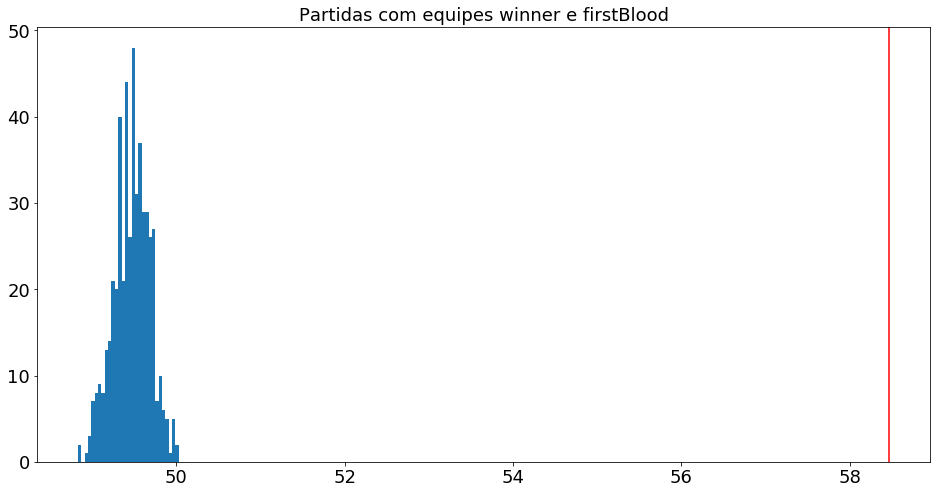

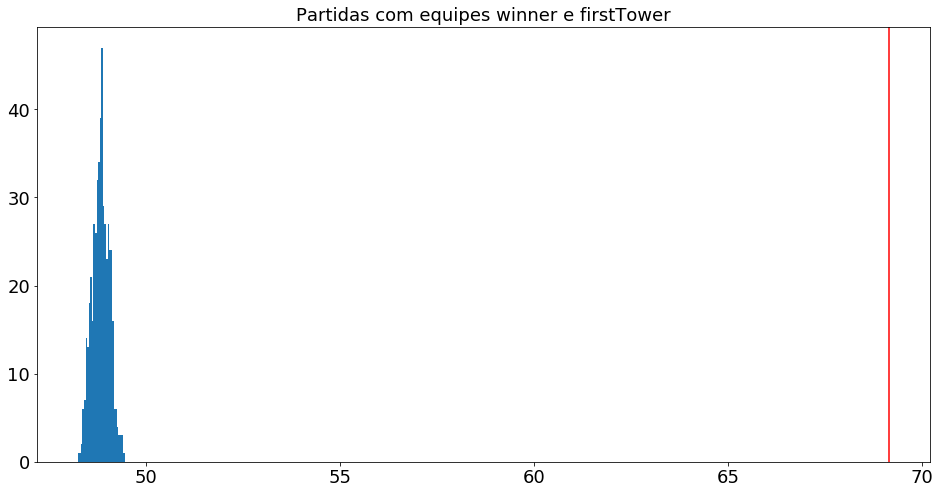

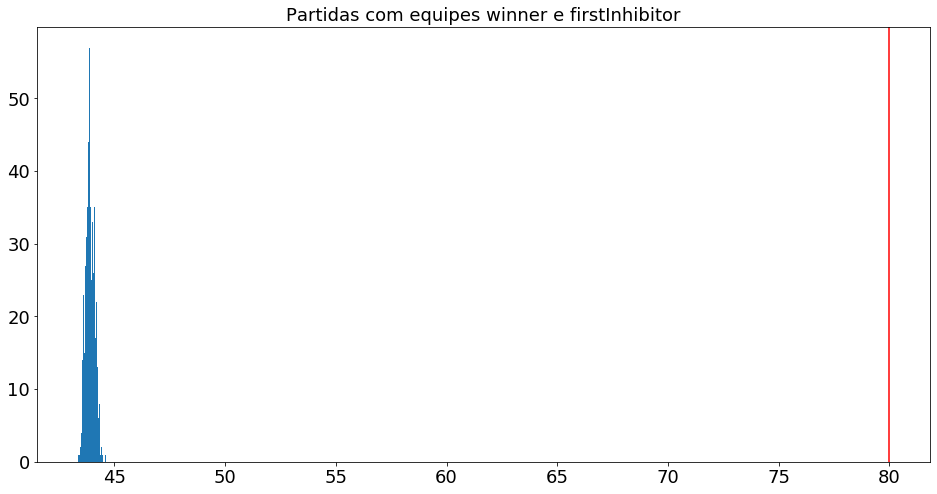

In [113]:
perm_first(df['winner'], df['firstBlood'])
perm_first(df['winner'], df['firstTower'])
perm_first(df['winner'], df['firstInhibitor'])

In [114]:
df2 = pd.read_csv('LeagueofLegendsExtended.csv')
df2 = df2.drop(['Unnamed: 0'], axis=1)
df2.columns

Index(['goldred at 5 min', 'goldblue at 5 min', 'goldred at last min',
       'goldblue at last min', 'goldred at 10 min', 'goldblue at 10 min',
       'killsDiff', 'riftHeraldDiff', 'baronKillsDiff', 'dragonKillsDiff',
       'inhibitorKillsDiff', 'towerKillsDiff', 'League', 'Year', 'Season',
       'Type', 'blueTeamTag', 'bResult', 'rResult', 'redTeamTag', 'gamelength',
       'golddiff', 'goldblue', 'bKills', 'bTowers', 'bInhibs', 'bDragons',
       'bBarons', 'bHeralds', 'goldred', 'rKills', 'rTowers', 'rInhibs',
       'rDragons', 'rBarons', 'rHeralds', 'blueTop', 'blueTopChamp',
       'goldblueTop', 'blueJungle', 'blueJungleChamp', 'goldblueJungle',
       'blueMiddle', 'blueMiddleChamp', 'goldblueMiddle', 'blueADC',
       'blueADCChamp', 'goldblueADC', 'blueSupport', 'blueSupportChamp',
       'goldblueSupport', 'blueBans', 'redTop', 'redTopChamp', 'goldredTop',
       'redJungle', 'redJungleChamp', 'goldredJungle', 'redMiddle',
       'redMiddleChamp', 'goldredMiddle', 'redAD

In [115]:
#perm_diff(df2, 'bTowers', 'rTowers', 'bResult')

In [116]:
#perm_diff(df2, 'bTowers', 'rTowers', 'bResult')

In [117]:
#perm_diff(df2, 'bKills', 'rKills', 'bResult')

In [118]:
#perm_diff(df2, 'bDragons', 'rDragons', 'bResult')

diff obs: 152.71751264510294
iteracoes: 0/500
iteracoes: 50/500
iteracoes: 100/500
iteracoes: 150/500
iteracoes: 200/500
iteracoes: 250/500
iteracoes: 300/500
iteracoes: 350/500
iteracoes: 400/500
iteracoes: 450/500


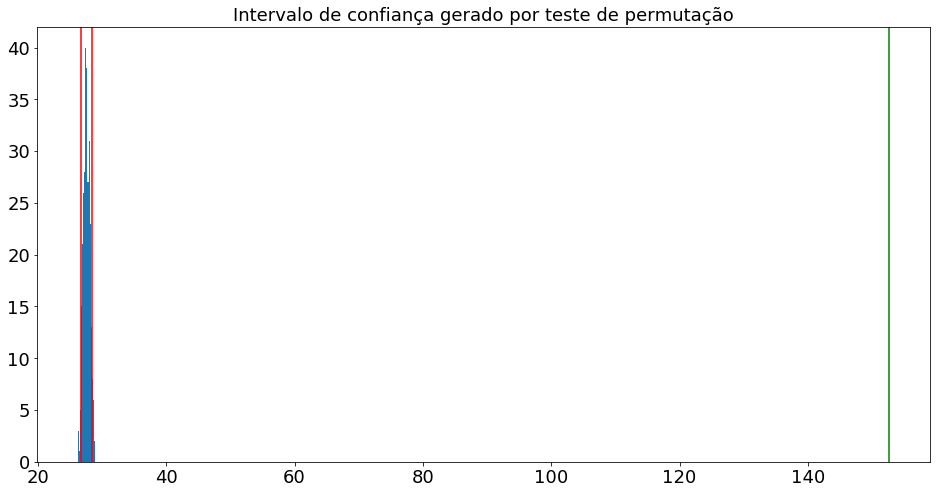

In [119]:
perm_diff(df2, 'goldred at 5 min', 'goldblue at 5 min', 'bResult')

diff obs: 533.0570852152068
iteracoes: 0/500
iteracoes: 50/500
iteracoes: 100/500
iteracoes: 150/500
iteracoes: 200/500
iteracoes: 250/500
iteracoes: 300/500
iteracoes: 350/500
iteracoes: 400/500
iteracoes: 450/500


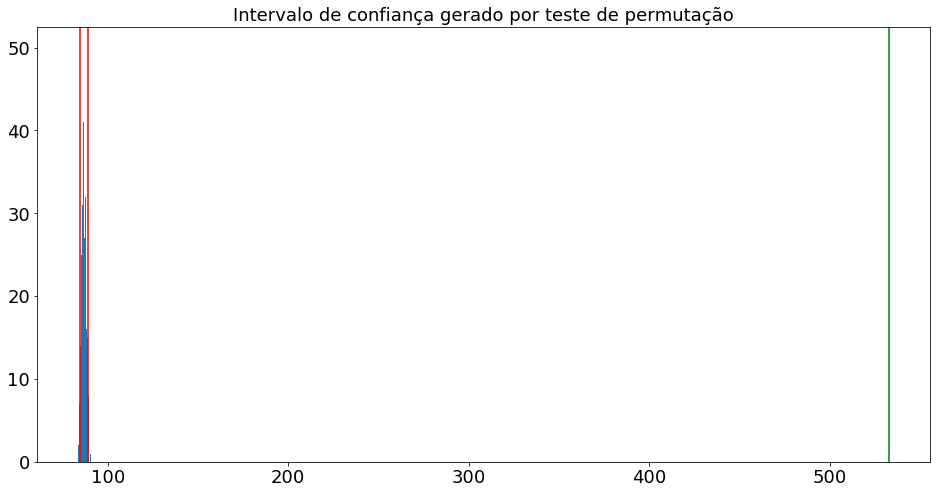

In [120]:
perm_diff(df2, 'goldred at 10 min', 'goldblue at 10 min', 'bResult')

diff obs: 10143.906621401737
iteracoes: 0/500
iteracoes: 50/500
iteracoes: 100/500
iteracoes: 150/500
iteracoes: 200/500
iteracoes: 250/500
iteracoes: 300/500
iteracoes: 350/500
iteracoes: 400/500
iteracoes: 450/500


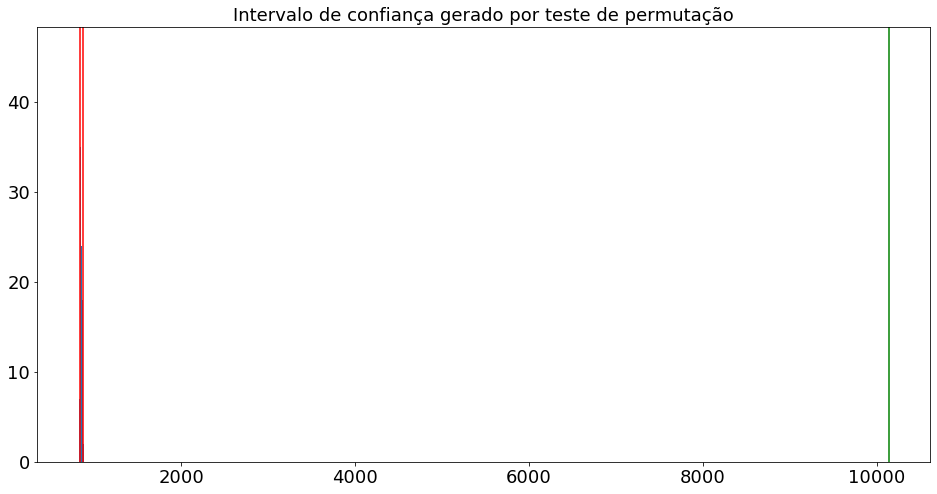

In [121]:
perm_diff(df2, 'goldred at last min', 'goldblue at last min', 'bResult')